## Get the outputs from each AlexNet layer to the experiment images
### (Using a randomly initialized, untrained AlexNet model)

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats
import os

In [2]:
import tensorflow as tf
from models_alexnet import alexnet
from models_alexnet import alexnet_wrapper


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
from utils import norm_image

In [4]:
#setup paths
STIM_PATH = "../data/full_res/"
SAVE_PATH = "../models/features/alexnet/"

In [7]:
#testing with one training set (sets of 120 images) - verify untrained looks different
with h5py.File(os.path.join(STIM_PATH,"Stimuli_Trn_FullRes_01.mat"),'r') as f:
    stim_set1 = f['stimTrn'][:]
#make the actual pixel values match the alexnet training images
stim_set1 = stim_set1+.5

#transpose the images so that they make sense
stim_set1 = stim_set1.T
stim_set1.shape
#add pretend color channels
N = stim_set1[:,:,:,np.newaxis]
stim_set1_rgb = np.tile(N,(1,1,1,3))
stim_set1_rgb.shape

#create image tensor
images = stim_set1_rgb
image_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
#resize for alexnet
resized_images = tf.image.resize_images(image_tensor, (224, 224))

In [8]:
model = alexnet(resized_images, train=False)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model

In [16]:
all_vars = tf.global_variables()

In [17]:
all_vars

[<tf.Variable 'conv1/weights:0' shape=(11, 11, 3, 96) dtype=float32_ref>,
 <tf.Variable 'conv1/bias:0' shape=(96,) dtype=float32_ref>,
 <tf.Variable 'conv2/weights:0' shape=(5, 5, 96, 256) dtype=float32_ref>,
 <tf.Variable 'conv2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv3/weights:0' shape=(3, 3, 256, 384) dtype=float32_ref>,
 <tf.Variable 'conv3/bias:0' shape=(384,) dtype=float32_ref>,
 <tf.Variable 'conv4/weights:0' shape=(3, 3, 384, 384) dtype=float32_ref>,
 <tf.Variable 'conv4/bias:0' shape=(384,) dtype=float32_ref>,
 <tf.Variable 'conv5/weights:0' shape=(3, 3, 384, 256) dtype=float32_ref>,
 <tf.Variable 'conv5/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'fc6/weights:0' shape=(12544, 4096) dtype=float32_ref>,
 <tf.Variable 'fc6/bias:0' shape=(4096,) dtype=float32_ref>,
 <tf.Variable 'fc7/weights:0' shape=(4096, 4096) dtype=float32_ref>,
 <tf.Variable 'fc7/bias:0' shape=(4096,) dtype=float32_ref>,
 <tf.Variable 'fc8/weights:0' shape=(4096, 1000) dtype=fl

In [19]:
# initialize tf Session and check that weights are crap
sess = tf.Session()
conv1_weights_tensor = tf.get_default_graph().get_tensor_by_name("conv1/weights:0")

In [23]:
# Initialize variables here
init_op_global = tf.global_variables_initializer()
sess.run(init_op_global)

In [24]:
sanity_weights = sess.run(conv1_weights_tensor)

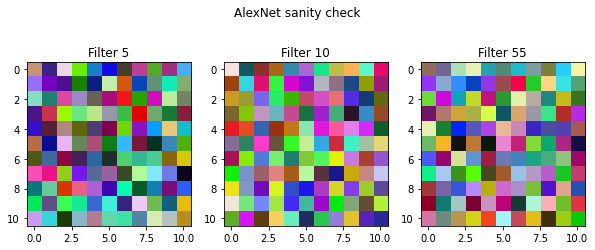

In [26]:
#plot select conv1 filters
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 4), nrows=1, ncols=3)
title = "AlexNet sanity check" 
fig.suptitle(title)

true_filter_1 = norm_image(sanity_weights[:,:,:,5])
ax1.imshow(true_filter_1)
ax1.set_title("Filter 5")

true_filter_5 = norm_image(sanity_weights[:,:,:,10])
ax2.imshow(true_filter_5)
ax2.set_title("Filter 10")

true_filter_10 = norm_image(sanity_weights[:,:,:,55])
ax3.imshow(true_filter_10)
ax3.set_title("Filter 55")

plt.savefig('../figures/alexnet_untrained_conv1_filters.png') #excellent

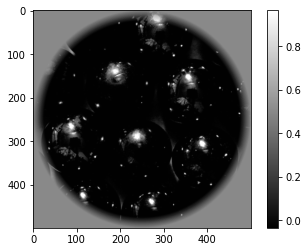

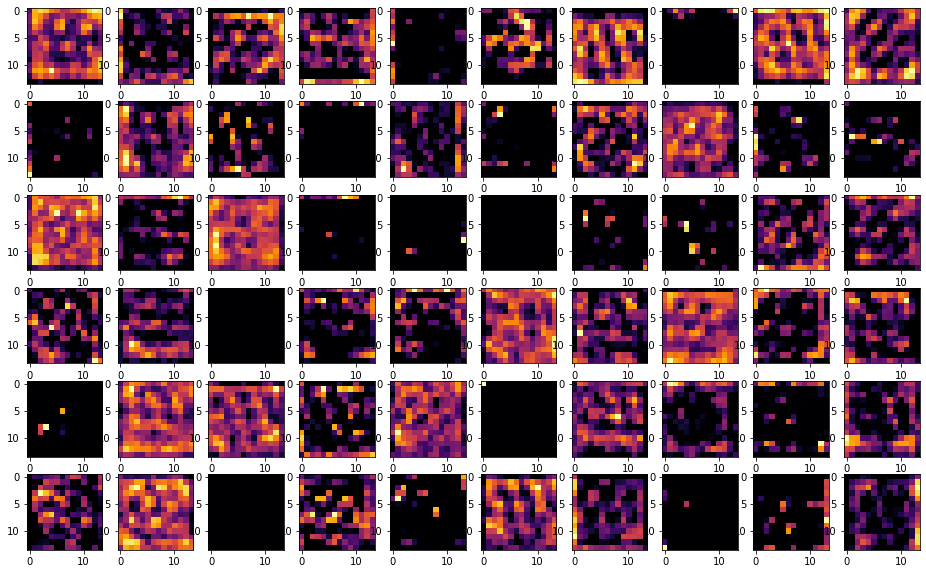

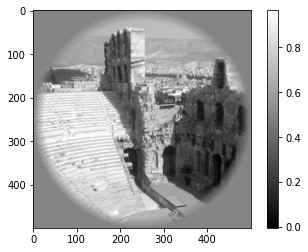

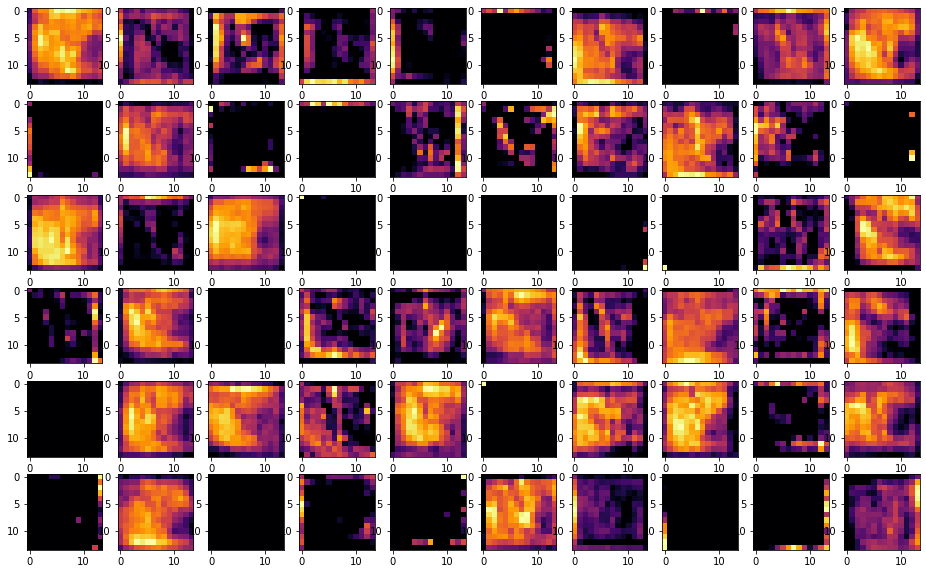

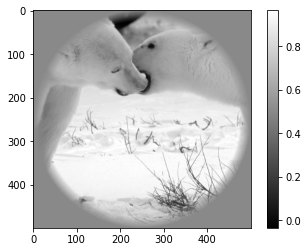

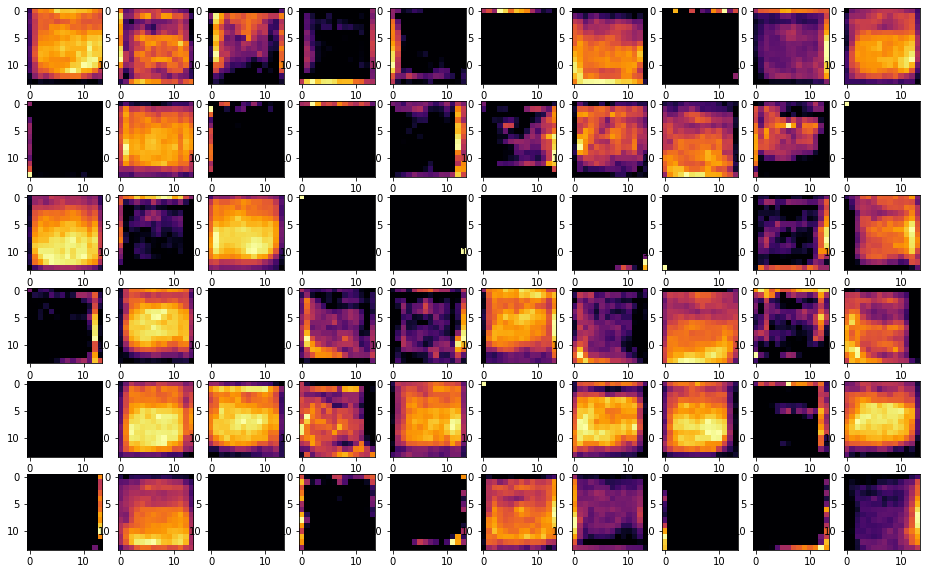

In [27]:
#check output to images from conv3
conv3_outputs = model.layers['conv3']
conv3_outputs = sess.run(conv3_outputs)

#visualize some features for kicks
for image_idx in [1, 10, 100]:
    plt.figure()

    plt.imshow(stim_set1[image_idx,:,:], cmap = "gray")
    plt.colorbar()

    fav_image = conv3_outputs[image_idx,:,:,:]
    fav_image = np.moveaxis(fav_image, -1, 0) #put num of features in first column

    fig = plt.figure(figsize=(16,10))

    for idx in range(60):
        ax = fig.add_subplot(6, 10, idx+1) 
        ax.imshow(fav_image[idx,:,:], cmap="inferno") 

In [28]:
num_train_batch = 15 #15th batch only has 20 images
stim_set = []

In [29]:
layer_keys = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7']
total_outputs = {}

In [32]:
# now let's do this for all the training images, not just the first batch, and for all layers

for idx in range(0,num_train_batch):
    tf.reset_default_graph()
    
    if idx < 9:
        base_str = ['Stimuli_Trn_FullRes_0','.mat']
    else:
        base_str = ['Stimuli_Trn_FullRes_','.mat']
            
    num = str(idx+1)
    
    fullfile = num.join(base_str)
    
    with h5py.File(os.path.join(STIM_PATH,fullfile),'r') as f:
        stim_set = f['stimTrn'][:]
        
    #make the actual pixel values match the alexnet training images
    stim_set = stim_set+.5

    #transpose the images so that they make sense
    stim_set = stim_set.T

    #add pretend color channels
    N = stim_set[:,:,:,np.newaxis]
    stim_set_rgb = np.tile(N,(1,1,1,3))
    
    #create image tensor
    batch_images = stim_set_rgb
    batch_image_tensor = tf.convert_to_tensor(batch_images, dtype=tf.float32)
    #resize for alexnet
    batch_resized_images = tf.image.resize_images(batch_image_tensor, (224, 224))
    
    # initialize model
    batch_convnet = alexnet(batch_resized_images)
    
    with tf.Session() as sess:
        init_op_global = tf.global_variables_initializer()
        sess.run(init_op_global)

        for layer in layer_keys:
            print(layer)
            # define output tensors of interest
            batch_outputs = batch_convnet.layers[layer]

            # run whatever tensors we care about
            batch_outputs = sess.run(batch_outputs)

            if idx == 0:
                total_outputs[layer] = batch_outputs
            else:
                total_outputs[layer] = np.concatenate((total_outputs[layer],batch_outputs),axis=0)

            print(total_outputs[layer].shape)
        

conv1
(120, 54, 54, 96)
conv2
(120, 27, 27, 256)
conv3
(120, 14, 14, 384)
conv4
(120, 14, 14, 384)
conv5
(120, 14, 14, 256)
fc6
(120, 4096)
fc7
(120, 4096)
conv1
(240, 54, 54, 96)
conv2
(240, 27, 27, 256)
conv3
(240, 14, 14, 384)
conv4
(240, 14, 14, 384)
conv5
(240, 14, 14, 256)
fc6
(240, 4096)
fc7
(240, 4096)
conv1
(360, 54, 54, 96)
conv2
(360, 27, 27, 256)
conv3
(360, 14, 14, 384)
conv4
(360, 14, 14, 384)
conv5
(360, 14, 14, 256)
fc6
(360, 4096)
fc7
(360, 4096)
conv1
(480, 54, 54, 96)
conv2
(480, 27, 27, 256)
conv3
(480, 14, 14, 384)
conv4
(480, 14, 14, 384)
conv5
(480, 14, 14, 256)
fc6
(480, 4096)
fc7
(480, 4096)
conv1
(600, 54, 54, 96)
conv2
(600, 27, 27, 256)
conv3
(600, 14, 14, 384)
conv4
(600, 14, 14, 384)
conv5
(600, 14, 14, 256)
fc6
(600, 4096)
fc7
(600, 4096)
conv1
(720, 54, 54, 96)
conv2
(720, 27, 27, 256)
conv3
(720, 14, 14, 384)
conv4
(720, 14, 14, 384)
conv5
(720, 14, 14, 256)
fc6
(720, 4096)
fc7
(720, 4096)
conv1
(840, 54, 54, 96)
conv2
(840, 27, 27, 256)
conv3
(840, 14,

In [33]:
#let's save the features as h5py to use for fitting in another notebook
h5f = h5py.File(os.path.join(SAVE_PATH,"alexnet_untrained_train_features.h5"), 'w')
for k, v in total_outputs.items():
    h5f.create_dataset(str(k), data=v)

In [34]:
h5f.close()

In [35]:
# and now for the validation images
tf.reset_default_graph()

total_val_outputs = {}

with h5py.File(os.path.join(STIM_PATH,"Stimuli_Val_FullRes.mat"),'r') as f:
        stim_set = f['stimVal'][:]
        
#make the actual pixel values match the alexnet training images
stim_set = stim_set+.5

#transpose the images so that they make sense
stim_set = stim_set.T

#add pretend color channels
N = stim_set[:,:,:,np.newaxis]
stim_set_rgb = np.tile(N,(1,1,1,3))

#create image tensor
val_images = stim_set_rgb
val_image_tensor = tf.convert_to_tensor(val_images, dtype=tf.float32)
#resize for alexnet
val_resized_images = tf.image.resize_images(val_image_tensor, (224, 224))

# initialize model
val_convnet = alexnet(val_resized_images)

with tf.Session() as sess:
    init_op_global = tf.global_variables_initializer()
    sess.run(init_op_global)

    for layer in layer_keys:
        print(layer)

        # define output tensors of interest
        val_outputs = val_convnet.layers[layer]

        # run whatever tensors we care about
        total_val_outputs[layer] = sess.run(val_outputs)

        print(total_val_outputs[layer].shape)

conv1
(120, 54, 54, 96)
conv2
(120, 27, 27, 256)
conv3
(120, 14, 14, 384)
conv4
(120, 14, 14, 384)
conv5
(120, 14, 14, 256)
fc6
(120, 4096)
fc7
(120, 4096)


In [36]:
#let's save the features as h5py to use for fitting in another notebook
valh5f = h5py.File(os.path.join(SAVE_PATH,"alexnet_untrained_val_features.h5"), 'w')
for k, v in total_val_outputs.items():
    valh5f.create_dataset(str(k), data=v)

In [37]:
valh5f.close()